# Visualise the tracked MHWs

In [1]:
import xarray as xr
import numpy as np
import matplotlib.pylab as plt
import matplotlib.cm as cm
import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature

from tempfile import TemporaryDirectory
from getpass import getuser
from pathlib import Path
from dask.distributed import Client, LocalCluster
import subprocess
import re

import dask
import pyicon as pyic  # Necessary for unstructured plotting of ICON data
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

----Start loading pyicon.
----Start loading pyicon.
----Pyicon was loaded successfully.
----Pyicon was loaded successfully.


In [2]:
scratch_dir = Path('/scratch') / getuser()[0] / getuser() / 'mhws' 
zarr_fpath_tgrid = scratch_dir  / f'fpath_tgrid.zarr'

## Start Dask Cluster

In [3]:
cluster_scratch = Path('/scratch') / getuser()[0] / getuser() / 'clients'
dask_tmp_dir = TemporaryDirectory(dir=cluster_scratch)
dask.config.set(temporary_directory=dask_tmp_dir.name)

## Local Cluster
cluster = LocalCluster(n_workers=32, threads_per_worker=4)
client = Client(cluster)

remote_node = subprocess.run(['hostname'], capture_output=True, text=True).stdout.strip().split('.')[0]
port = re.search(r':(\d+)/', client.dashboard_link).group(1)
print(f"Forward with Port = {remote_node}:{port}")

client.dashboard_link

/home/b/b382615/opt/anaconda3/lib/python3.10/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 36351 instead
  warnings.warn(


Forward with Port = l40040:36351


'http://127.0.0.1:36351/status'

## Import Processed Data

In [4]:
blobs = xr.open_zarr(str(scratch_dir / '02_tracked_unstruct.zarr'), chunks={'time': 10, 'ncells': -1}).labels
blobs

/home/b/b382615/opt/anaconda3/lib/python3.10/site-packages/xarray/core/dataset.py:282: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 10. This could degrade performance. Instead, consider rechunking after loading.
  warnings.warn(


<xarray.DataArray 'labels' (time: 13148, ncells: 14886338)> Size: 783GB
dask.array<open_dataset-labels, shape=(13148, 14886338), dtype=int32, chunksize=(10, 14886338), chunktype=numpy.ndarray>
Coordinates:
    lat      (ncells) float64 119MB dask.array<chunksize=(14886338,), meta=np.ndarray>
    lon      (ncells) float64 119MB dask.array<chunksize=(14886338,), meta=np.ndarray>
  * ncells   (ncells) int64 119MB 0 1 2 3 ... 14886335 14886336 14886337
  * time     (time) datetime64[ns] 105kB 2004-01-01T23:59:00 ... 2039-12-30T2...
Attributes:
    Closing Radius:                250.0
    Effective Closing Radius (N):  43.25
    Final Objects Tracked:         711678
    Inital Objects Identified:     497649718
    Minimum Size (N):              36.0
    Percent Area Accept:           0.7482749995500836
    Percent Area Reject:           0.2517250004499164
    Resolution:                    5.0
    Size Quantile Threshold:       0.9

(<GeoAxes: title={'right': '2004-04-10T23:59:00'}>,
  <matplotlib.colorbar.Colorbar at 0x15524f4940d0>])

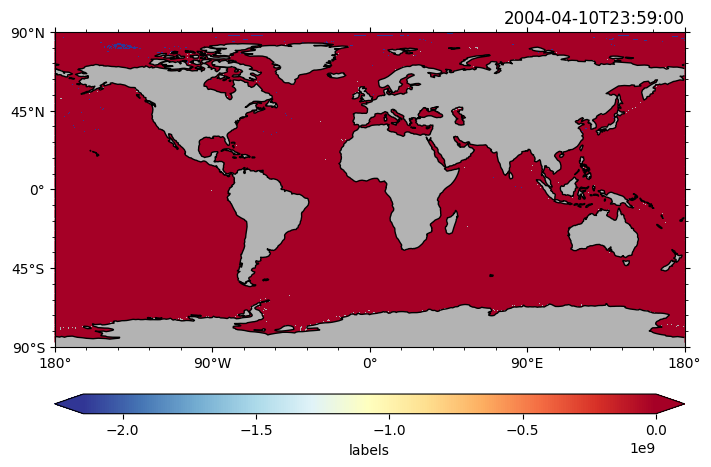

In [6]:
blobs.isel(time=100).pyic.plot(fpath_tgrid=zarr_fpath_tgrid)

In [ ]:
ds = xr.open_zarr(str(scratch_dir / '01_preprocess_unstruct.zarr'), chunks={'time': 10, 'ncells': -1})
ds

## Plot some Blobs

In [ ]:
blobs_first_day = blobs.sel(time=slice('2020-01-01', '2021-01-01')).resample(time='MS').first() 

plt.rc('text', usetex=False)  # Use built-in math text rendering
plt.rc('font', family='serif')

cmap = 'tab20c'

fig = plt.figure(figsize=(21,5))
fig.set_facecolor('w')

ax1 = plt.subplot(1,3,1,projection=ccrs.Robinson())
cb1 = fig.colorbar(cm.ScalarMappable(cmap=cmap), ax=ax1, shrink=0.6)
blobs_first_day.isel(time=0).pyic.plot(ax=ax1,cax=cb1.ax, cbar_pos='vertical', cmap=cmap)
ax1.add_feature(cfeature.LAND,facecolor='darkgrey')
ax1.coastlines()
gl1 = ax1.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                linewidth=1, color='gray', alpha=0.5, linestyle='--')


ax2 = plt.subplot(1,3,2,projection=ccrs.Robinson())
cb2 = fig.colorbar(cm.ScalarMappable(cmap=cmap), ax=ax2, shrink=0.6)
blobs_first_day.isel(time=1).pyic.plot(ax=ax2,cax=cb2.ax, cbar_pos='vertical', cmap=cmap)
ax2.add_feature(cfeature.LAND,facecolor='darkgrey')
ax2.coastlines()
gl2 = ax2.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                linewidth=1, color='gray', alpha=0.5, linestyle='--')



ax3 = plt.subplot(1,3,3,projection=ccrs.Robinson())
cb3 = fig.colorbar(cm.ScalarMappable(cmap=cmap), ax=ax3, shrink=0.6)
blobs_first_day.isel(time=3).pyic.plot(ax=ax3,cax=cb3.ax, cbar_pos='vertical', cmap=cmap)
ax3.add_feature(cfeature.LAND,facecolor='darkgrey')
ax3.coastlines()
gl3 = ax3.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                linewidth=1, color='gray', alpha=0.5, linestyle='--')

## Global MHW Frequency

In [9]:
mhw_frequency = xr.where((blobs == 0) | np.isnan(blobs), 0.0, 1.0).mean('time')
mhw_frequency.pyic.plot(cmap='hot_r', fpath_tgrid=zarr_fpath_tgrid)

## Plot STD Rolling Mean used for Normalisation

In [10]:
ds.stdev.isel(ncells=10000).plot()

## Find the longest MHWs

In [11]:
final_objects_tracked = blobs.attrs['Final Objects Tracked']
labels = np.arange(final_objects_tracked)

occurrence_array = xr.apply_ufunc(
    lambda blobs_data, labels: np.isin(labels, blobs_data[..., np.newaxis]),  # Check presence...
    blobs,
    input_core_dims=[['ncells']],
    output_core_dims=[['label']],
    vectorize=True,
    dask='parallelized',
    output_dtypes=[bool],
    output_sizes={'label': final_objects_tracked},
    kwargs={'labels': labels}
)

In [12]:
label_occurrence = occurrence_array.sum(dim='time').compute()

In [13]:
longest_mhws = label_occurrence.argsort()[::-1]

In [14]:
for label in longest_mhws[:10].values:
    print(f"Label: {label}, Time: {label_occurrence.sel(label=label).item()} days")

## Plot a few long MHWs

In [16]:
fig, axes = plt.subplots(3, 3, figsize=(12, 12))
axes = axes.flatten()

for i, label in enumerate(longest_mhws[:9]):
    ax = axes[i]
    mhw_intensity = xr.where(blobs == longest_mhws[i], 1, 0).sum(dim='time')
    mhw_intensity.isel(time=i).pyic.plot(ax=ax, cbar_pos='vertical', cmap='hot_r', cbar_str='Duration (days)', fpath_tgrid=zarr_fpath_tgrid)
    ax.set_title(f'Label: {label}',size=14)

# Adjust layout
plt.tight_layout()
plt.show()